[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PennNGG/Quantitative-Neuroscience/blob/master/Concepts/Python/Multiple%20Comparisons.ipynb)

# Definitions

The multiple comparisons problem in statistics occurs when multiple statistical inferences are done simultaneously, which greatly increases the probability that any one inference will yield an erroneous result, by chance. A lot has been written about this problem, including:

- [Its prevalence in fMRI data analysis](https://www.sciencedirect.com/science/article/pii/S1053811912007057?via%3Dihub) (including a compelling illustration by this [prizewinning study](https://blogs.scientificamerican.com/scicurious-brain/ignobel-prize-in-neuroscience-the-dead-salmon-study/)\)

- [How Baysian methods can avoid the problem](http://www.stat.columbia.edu/~gelman/research/published/multiple2f.pdf).

- [General approaches for correcting for multiple comparisons](http://www.biostathandbook.com/multiplecomparisons.html).

Here we will provide some intuition for the problem using a simple thought experiment, to sensitize you to how much of a problem it can be. Consider performing the same statistical test on *N* different samples corresponding to, say, different voxels in fMRI data, using a *p*-value of $\alpha$ (typically 0.05) for each test.

Thus, for any one test, the probability of getting a Type I error (rejecting $H_0$ when $H_0$ is true) is $\alpha$:

$p_{error}=\alpha$

For two tests, the probably of getting a Type I error for either test is just one minus the combined probability of not getting a Type I error from either one:

$p_{error}=1-(1-\alpha)(1-\alpha)$

For *N* tests, the probably of getting a Type I error for either test is just one minus the combined probability of not getting a Type I error from any one:

$p_{error}=1-(1-\alpha)^N$

Run the cell below to see that the probability of getting a Type I error under these conditions grows rapidly with *N*, implying that it becomes very, very likely that you will get a "statistically significant result" just by chance if you do enough tests:

Text(0, 0.5, '$P_{error}$')

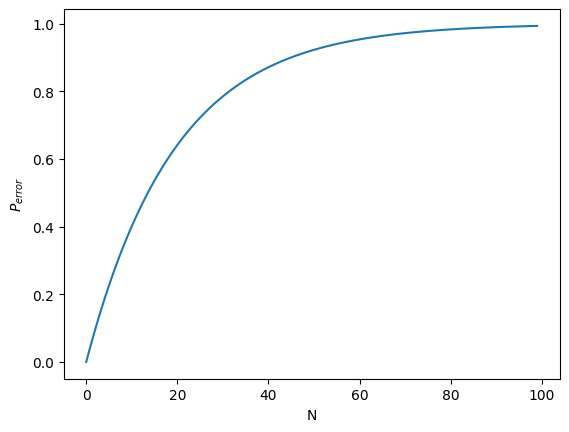

In [1]:
import matplotlib.pyplot as plt
import numpy as np

alpha = 0.05
N = np.arange(0,100)
plt.plot(N, 1-(1-alpha)**N)
plt.xlabel('N')
plt.ylabel('$P_{error}$')

# Correcting for multiple comparisons



There are a number of different methods that can be used to [correct for this problem](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5506159/). Below are two common methods.




## Bonferroni correction

The simplest way to correct for Type I errors (false positives) in multiple comparisons is to divide $\alpha$ by the number of comparisons, known as the [Bonferroni correction](https://mathworld.wolfram.com/BonferroniCorrection.html). This is a very conservative test that is typically used when the number of comparisons is relatively small and you want to avoid Type I errors.

## Benjamini–Hochberg procedure


Another approach is to more carefully control the false-discovery rate using the [Benjamini–Hochberg procedure](https://www.jstor.org/stable/2346101?seq=1#metadata_info_tab_contents):

1\. Rank the individual *p*-values in ascending order, labeled *i*=1...*n*

2\. For each *p*-value, calculate its "critical value" as (*i*/*n*)*Q*, where *i* is the rank, *n* is the total number of tests, and *Q* is the false discovery rate (a percentage) that you choose (typically 0.05).

3\. In your rank-ordered, original *p*-values, find the largest value that is smaller than its associated critical value; this *p*-value is the new criterion (i.e., reject $H_0$ for all cases for which *p* ≤ this value).

# Exercise

In this exercise we will run through an example of correcting for multiple comparisons with both the Benjamini-Hochberg procedure and the more conservative Bonferroni correction.

First, simulate multiple (say, 1000) t-tests comparing two samples with equal means and standard deviations, and save the p-values. Obviously, at p<0.05 we expect that ~5% of the simulations to yield a "statistically significant" result (of rejecting the NULL hypothesis that the samples come from distributions with equal means).

Second, once you have the simulated p-values, apply both methods to address the multiple comparisons problem.

Third, set the sample 1 and sample 2 means to be 1 and 2 respectively, and re-run the exercise. What do you notice? What if you make the difference between means even greater?

In [2]:
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import multipletests

# Settings
np.random.seed(42)
n_tests = 1000
n_per_group = 30

# Function to simulate t-tests
def simulate_ttests(mean1, mean2, n_tests=1000, n_per_group=30):
    p_values = []
    for _ in range(n_tests):
        x = np.random.normal(mean1, 1, n_per_group)
        y = np.random.normal(mean2, 1, n_per_group)
        _, p = stats.ttest_ind(x, y)
        p_values.append(p)
    return np.array(p_values)

# Function to apply corrections and print results
def analyze_results(p_values, label):
    # Uncorrected
    raw_sig = np.sum(p_values < 0.05)

    # Bonferroni correction
    bonf_reject, bonf_pvals, _, _ = multipletests(p_values, alpha=0.05, method='bonferroni')

    # Benjamini-Hochberg correction
    bh_reject, bh_pvals, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')

    # Print results
    print(f"\nResults for {label}:")
    print(f"  Raw p < 0.05: {raw_sig}")
    print(f"  Bonferroni significant: {np.sum(bonf_reject)}")
    print(f"  Benjamini-Hochberg significant: {np.sum(bh_reject)}")

# Case 1: Null hypothesis (equal means)
p_values_null = simulate_ttests(1, 1, n_tests, n_per_group)
analyze_results(p_values_null, "Null (means equal)")

# Case 2: True effect (means differ: 1 vs 2)
p_values_alt = simulate_ttests(1, 2, n_tests, n_per_group)
analyze_results(p_values_alt, "True effect (means 1 vs 2)")



Results for Null (means equal):
  Raw p < 0.05: 41
  Bonferroni significant: 0
  Benjamini-Hochberg significant: 0

Results for True effect (means 1 vs 2):
  Raw p < 0.05: 964
  Bonferroni significant: 344
  Benjamini-Hochberg significant: 964


If I kept increasing the means to 1 vs 3 or 4, the effect would then be larger and so all tests (including the more strict Bonferroni test) would say that all the significant results are real.

# Additional Resources


How to correct for multiple comparisons in [Matlab](https://www.mathworks.com/help/stats/multcompare.html), [R](https://stat.ethz.ch/R-manual/R-devel/library/stats/html/p.adjust.html), and [Python](https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.multipletests.html)

# Credits

Copyright 2021 by Joshua I. Gold, University of Pennsylvania